# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## Question 1

Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.

### Approach

We will use the same model as in part 2 notebook, but now we will also back propagate
the loss into the word embeddings itself. This will mean that as the model learns,
the word embeddings would also update, causing the encoding of the words to change.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from common_utils import UNK_TOKEN,EMBEDDING_DIM,SAVE_DIR,VOCAB_PATH,EMBEDDING_MATRIX_PATH,WORD2IDX_PATH,IDX2WORD_PATH,tokenize, EmbeddingMatrix, CustomDatasetPreparer
np.random.seed(42)
torch.manual_seed(0)

/Users/keenlim/Library/Caches/pypoetry/virtualenvs/sc4002-nlp-Ehnma5G0-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, word_embedding:np.ndarray):
        super(RNNModel, self).__init__()

        # Word2Vec embedding layer
        # freeze=False to enable updates to embeddings
        self.word2vec_embeddings = nn.Embedding.from_pretrained(torch.tensor(word_embedding), freeze=False)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Look up word embeddings
        x = self.word2vec_embeddings(x)

        # Pass through RNN
        x, _ = self.rnn(x)

        # Take the last hidden state
        x = x[:, -1, :]

        # Pass through fully connected layer
        x = self.fc(x)

        return x


hidden_dim = 128
output_dim = 1
# Load EmbeddingMatrix
w2v_model = EmbeddingMatrix.load()

# Create RNN model
model = RNNModel(w2v_model.vocab_size,
                 w2v_model.dimension,
                 hidden_dim,
                 output_dim,
                 w2v_model.embedding_matrix)

# Create optimizer
optimizer = optim.Adam(model.parameters())

## Question 2

### Approach

As discussed in part 1, we have mentioned 2 approaches to handling of the
OOV words. We will now demonstrate the first approach, which is to replace the OOV
words with a special token. We will replace the OOV words with a special token
`<UNK>`.

In [3]:
import json
from common_utils import EMBEDDING_DIM, EMBEDDING_MATRIX_PATH, IDX2WORD_PATH, UNK_TOKEN, WORD2IDX_PATH, load_glove_embeddings


w2v_model = EmbeddingMatrix.load()
extended_vocab = w2v_model.vocab
extended_vocab.add(UNK_TOKEN)

# mapping of words to indices and vice versa
word2idx = {word: idx for idx, word in enumerate(sorted(extended_vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size_extended = len(extended_vocab)
embedding_matrix = np.zeros((vocab_size_extended, EMBEDDING_DIM))

print("Building embedding matrix...")

glove_dict = load_glove_embeddings()

for word in extended_vocab:
    idx = word2idx[word]
    # if word is in glove vocab, use glove vector
    if word in glove_dict:
        embedding_matrix[idx] = glove_dict[word]
    else:
        # use random vector for unknown words
        if word == UNK_TOKEN:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
        else:
            # remove the unknown word from the vocab
            # embedding_matrix[idx] = embedding_matrix[word2idx[UNK_TOKEN]]
            word2idx.pop(word)
            idx2word.pop(idx)

print("Embedding matrix built successfully.")

np.save(EMBEDDING_MATRIX_PATH, embedding_matrix)
print(f"Embedding matrix saved as '{EMBEDDING_MATRIX_PATH}'.")

with open(WORD2IDX_PATH, 'w', encoding='utf-8') as f:
    json.dump(word2idx, f, ensure_ascii=False, indent=4)
print(f"Mapping 'word2idx' saved as '{WORD2IDX_PATH}'.")

with open(IDX2WORD_PATH, 'w', encoding='utf-8') as f:
    json.dump(idx2word, f, ensure_ascii=False, indent=4)
print(f"Mapping 'idx2word' saved as '{IDX2WORD_PATH}'.")


Building embedding matrix...
Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
Embedding matrix built successfully.
Embedding matrix saved as './result/embedding_matrix.npy'.
Mapping 'word2idx' saved as './result/word2idx.json'.
Mapping 'idx2word' saved as './result/idx2word.json'.


For the second approach, we will use the FastText embeddings, which are trained on
subword information. This will help in encoding the OOV words as well.

In [41]:
# Implementation of FastText for word embedding
from gensim.models import FastText

# Load Word2Vec model
w2v_model = EmbeddingMatrix.load()

# Create a list of words from the Word2Vec model
words = list(w2v_model.vocab)

# Create a FastText model with the same dimensions as the Word2Vec model
# fasttext_model = FastText(size=w2v_model.dimension, window=5, min_count=1, workers=4)

# Build the FastText vocabulary
# fasttext_model.build_vocab(words)

# Initialize embeddings with Word2Vec embeddings
# for word in words:
#     fasttext_model.wv[word] = w2v_model[word]


### Part 3.2 BiGru Model

The weight matrix will be created by BatchIterator class  based on the Glove word vectors we want to use and vocabularly word2index dictionary. For each word, index pair from word2index, the weight matrix at the position equals index will be set with the Glove vector that represents given word. 

For words that haven't been found in the Glove mapping, the random vector will be initialised. Then the weight matrix will be passed to the embedding layer as its parameters. 

It is very important to set the embedding_layer.weight.requires_grad = False, so that weights will not be updated during the training. After the GRU layer, extra features will be concatenated toehter with max-pooled, avg-pooled and last hidden size. The concatenated tensor will be next passed to the linear layer, so we have to set the input size to hidden_size * 3 + num_features.

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from common_utils import EmbeddingMatrix, UNK_TOKEN, EMBEDDING_DIM, tokenize
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
np.random.seed(42)
torch.manual_seed(0)

In [5]:
# Load word2vec embedding matrix
w2v_model = EmbeddingMatrix.load()
word2idx = w2v_model.word2idx

In [6]:
BATCH_SIZE = 64
dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    word2idx=word2idx,
    unk_token=UNK_TOKEN,
    max_len=512,
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [7]:
class BiGRU(nn.Module):
    """
    BiDirectional GRU neural network model with pre-trained word embeddings.

    Parameters
    -----------
    hidden_size: int 
        Number of features in the hidden state
    weight_matrix: numpy.ndarray 
        Matrix of pre-trained word embeddings (word_embedding)
    output_size: int
        Number of classes 
    n_layer: int, optional (default=1)
        Number of stacked recurrent layers. 
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout. 
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU. 
    """

    def __init__(self, hidden_size, weights_matrix, output_size, n_layers=1, dropout=0.2, spatial_dropout=True, bidirectional=True):

        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()

        # Initialise attributes
        self.hidden_size = hidden_size 
        self.weights_matrix = weights_matrix
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1

        self.vocab_size, self.embedding_dim = self.weights_matrix.shape 

        # Embedding layer - Convert words into vectors of numbers that capture their meaning from pretrained word embeddings.
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix, dtype=torch.float), freeze=False)

        # Define dropout layers - Randomly set some neurons to zero during training to prevent overfitting
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout1d(self.dropout_p)
        
        # Define GRU layer 
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True, bidirectional=self.bidirectional)

        # Linear layer input size is equal to hidden_size * 3 + n_extra_feat, becuase
        # we are concatenating max_pooling ,avg_pooling, last hidden state and additional features
        self.linear = nn.Linear(self.hidden_size * 3, self.output_size)
    
    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract input_size (Batch size)
        self.input_size = input_seq.size(0)
        
        # Embeddings shapes of input
        # Input: (input_size,  seq_length)
        # Output: (input_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)
        

        # Pass the emebedding layer to the dropout layer
        if self.spatial_dropout:
            # Convert to (input_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            # Dropout1d layer
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (input_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)

        else:
            emb_out = self.dropout(emb_out)
        
        # Pack padded batch of sequences for RNN module
        # Removes the padding and concatenates the sequences along the time dimension
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths, batch_first=True, enforce_sorted=False)

        # Pass through the GRU Layer      
        gru_out, hidden = self.gru(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # hidden (h_n) comprises the hidden states after the entire sequence

        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, input_size, hidden_size)
        # Separate hidden state layers
        # Process the hidden layer
        hidden = hidden.view(self.n_layers, self.n_directions, self.input_size, self.hidden_size)
        last_hidden = hidden[-1]

        # Since Bidirectional: Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)

        
        # Pad a packed batch
        gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
              
        # Combine the GRU outputs
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        
        # Get Max and Average Pooling
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.input_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (input_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / lengths.view(-1,1).type(torch.FloatTensor) 

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor (Combining all features)
        concat_out = torch.cat([last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # Pass through the linear layer and apply Softmax layer
        out = self.linear(concat_out)
        return out

  

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 40 
spatial_dropout = True

# Load the weights matrix
weights = np.load('result/embedding_matrix.npy')

# Create BiGru model 
model = BiGRU(hidden_size, weights, output_size, n_layers, dropout, spatial_dropout, bidirectional=True)
print(model)

# Create loss function
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)

BiGRU(
  (embedding): Embedding(16164, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (gru): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)


In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler):

    model.train()
    best_val_loss = np.inf
    patience = 3 # Number of epochs to wait before stopping
    trigger_times = 0

    for epoch in range(num_epochs):
        total_loss = 0
        correct_preds = 0 
        total_samples = 0
        for batch in train_loader:
            sequences, features, lengths, labels = batch 

            # Move tensors to device (GPU or CPU)
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass 
            outputs = model(sequences, features, lengths)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted==labels).sum().item()
            total_samples += labels.size(0)
        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss 
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early Stopping at {epoch+1}')
                break

        

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct_pred = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in data_loader:
            sequences, features, lengths, labels = batch
            
            # Move tensors to device
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences, features, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Predictions
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_pred += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_pred / total_samples
    # print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy
    

In [10]:
EPOCHS = 40
train(model, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler)

Epoch [1/40], Train Loss: 0.6896, Train Accuracy: 0.5397, Val Loss: 0.6736, Val Accuracy: 0.5826
Epoch [2/40], Train Loss: 0.6029, Train Accuracy: 0.6985, Val Loss: 0.5655, Val Accuracy: 0.7158
Epoch [3/40], Train Loss: 0.4201, Train Accuracy: 0.8059, Val Loss: 0.4855, Val Accuracy: 0.7636
Epoch [4/40], Train Loss: 0.2757, Train Accuracy: 0.8903, Val Loss: 0.4782, Val Accuracy: 0.7683
Epoch [5/40], Train Loss: 0.2588, Train Accuracy: 0.8977, Val Loss: 0.4790, Val Accuracy: 0.7692
Epoch [6/40], Train Loss: 0.2441, Train Accuracy: 0.9042, Val Loss: 0.4811, Val Accuracy: 0.7720
Early Stopping at 7


In [11]:
evaluate(model, val_loader)

(0.48137613079127145, 0.7720450281425891)

In [12]:
evaluate(model, test_loader)

(0.4265192002058029, 0.799249530956848)

In [13]:
test_loss, test_accuracy = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4265, Test Accuracy: 0.7992


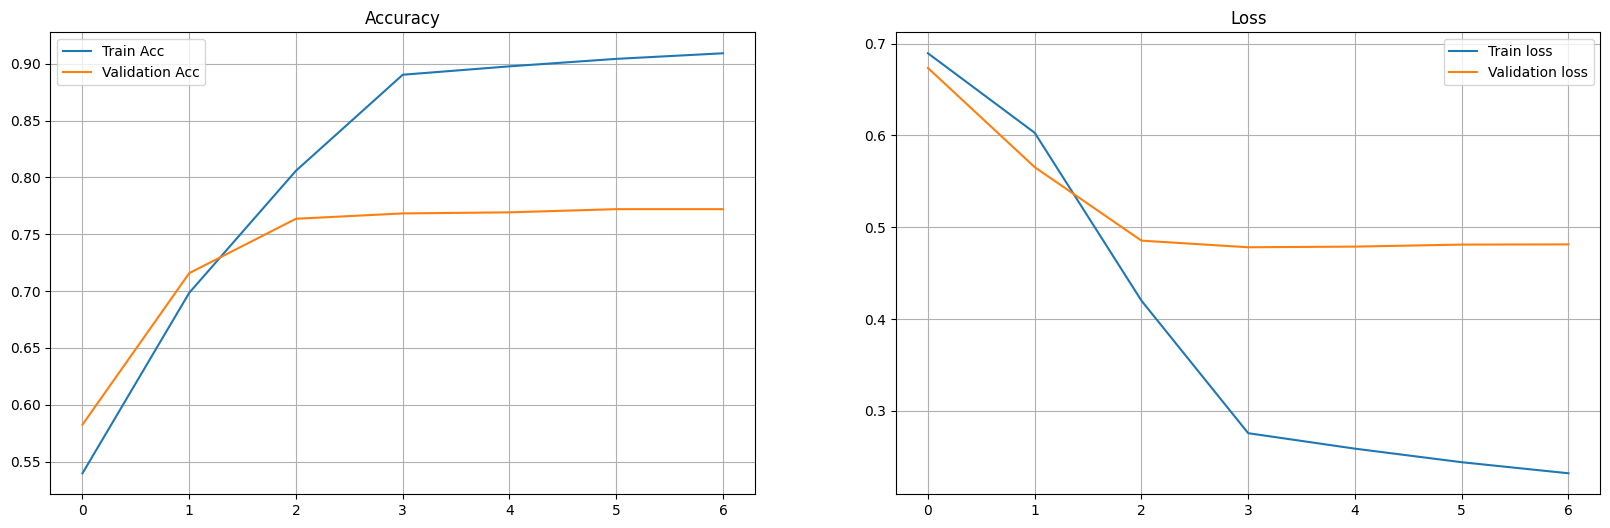

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.
